 - Student name: Steve Newman
 - Student pace: part time
 - Scheduled project review date/time: Tues. June 30 3:00 pm EST
 - Instructor name: James Irving PhD
 - Blog post URL:https://medium.com/p/a4baec51040b/edit

# NLP Sentiment Analysis Overview

The business case for this project was to identify negative sentiment tweets about brand specific products for the purpose of improving the brand's reputation. A Natural Language Processing model was deployed using various classifiers and Tfidf Vectorizers. The most significant metric used to evaluate performance was "Recall" specifically on the "Negative" class. 

A supervised learning method was used in which the training and test sets were labeled with a corresponding sentiment. An important caveat is that the models were optimized to identify negative sentiments. The results of neutral and positive sentiments were not considered for the success of the analysis.

# Methodology

Obtaining optimal results, consisted of the following method:
 - Import Packages and Functions
 - Exploratory Data Analysis (EDA)
 - Train/Test/Split
 - Test multiple classifiers in simple pipelines
 - Select a high performing pipeline and use balancing techniques to further optimize
 - Attempt to further improve model by employing a grid search of relevant parameters
 - Visualize results

In [81]:
from IPython.display import clear_output
!pip install -U fsds_100719
clear_output()
from fsds_100719.imports import *


In [82]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [83]:
def evaluate_model(clf, y_trn, y_true, y_pred, X_trn, X_true):
    
    '''
    Calculates and displays the following: Train and Test Score, Classification Report, 
    and Confusion Matrix.
    
        Parameters:
            
            clf: classifier or instanciated model from run_model function
            y_trn: y train from test, train, split
            y_true: y test from test, train, split
            y_pred: y hat test from run_model fuction
            X_trn: X train from test, train, split
            X_true: X test from test, train, split
    
    '''
    # Calculates and displays train and test scores.
    train_score = clf.score(X_trn,y_trn)
    test_score = clf.score(X_true,y_true)
    print(f"Train score= {train_score}")
    print(f"Test score= {test_score}\n")
    
    # Displays Classification Report / Scores 
    print(metrics.classification_report(y_true,y_pred))
    
    # Displays Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,4))
    metrics.plot_confusion_matrix(clf,X_true,y_true,cmap="Reds",
                                  normalize='true',ax=ax)
    ax.set(title='Confusion Matrix')
    ax.grid(False)
    

# EDA

In [84]:
#Import data

data = pd.read_csv('product_review.csv',encoding= 'unicode_escape')

In [85]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [86]:
# Rename columns for ease to work with.

data.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)

In [87]:
data.shape

(9093, 3)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet      9092 non-null object
product    3291 non-null object
emotion    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [89]:
# Most of the null data is in the product column.

data.isnull().sum()

tweet         1
product    5802
emotion       0
dtype: int64

In [90]:
data.fillna('unknown', inplace=True)

In [91]:
# Rename 'emotions' for ease to work with.

emotion_dict = dict({"No emotion toward brand or product":"Neutral","Positive emotion":"Positive", "Negative emotion":"Negative", "I can't tell":"I can't tell"})

In [92]:
data['emotion'] = data['emotion'].map(emotion_dict)

In [93]:
data['emotion'].value_counts()

Neutral         5389
Positive        2978
Negative         570
I can't tell     156
Name: emotion, dtype: int64

In [94]:
data.isnull().sum()

tweet      0
product    0
emotion    0
dtype: int64

In [95]:
# Convert "tweet" data into string format.

data["tweet"]= data["tweet"].astype(str) 

In [96]:
# Add "text length" feature.

data['text length'] = data['tweet'].apply(len)

In [97]:
# Add "token length" feature.

data['token_length'] = [len(x.split(" ")) for x in data.tweet]
max(data.token_length)

33

In [98]:
data.isnull().sum()

tweet           0
product         0
emotion         0
text length     0
token_length    0
dtype: int64

In [99]:
data.shape

(9093, 5)

In [100]:
# Identify target variables.

data['emotion'].value_counts()

Neutral         5389
Positive        2978
Negative         570
I can't tell     156
Name: emotion, dtype: int64

In [101]:
bad_rows = data['emotion']== "I can't tell"

In [102]:
# Eliminate "I can't tell" variable.

data = data[~bad_rows]

In [103]:
data['emotion'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotion, dtype: int64

## Plot Numeric Features

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

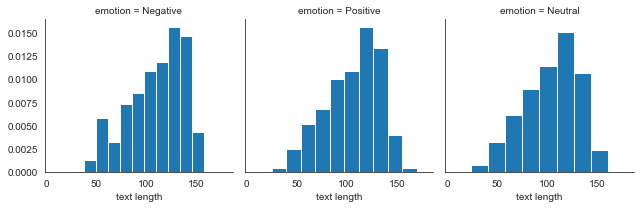

In [105]:
a = sns.FacetGrid(data,col='emotion')
a.map(plt.hist,'text length', density=True)

Plot shows similar distribution of "text length" across the three emotion types.

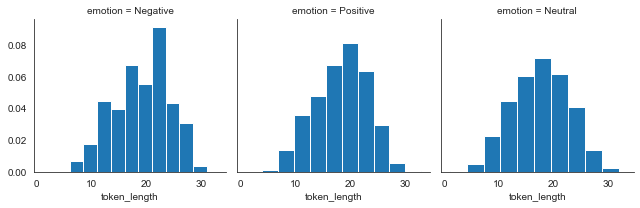

In [106]:
token_l = sns.FacetGrid(data,col='emotion')
token_l.map(plt.hist,'token_length', density=True)

Plot shows slightly more "tokens" are used in the negative emotion category versus the positive and neutral.

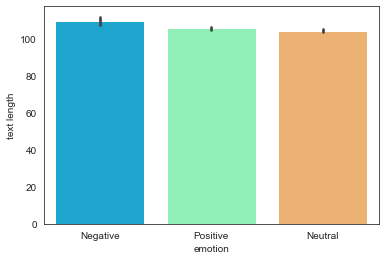

In [107]:
sns.barplot(x='emotion',y='text length',data=data,palette='rainbow')

Barplot shows a very slight increase of text length versus other sentiments.

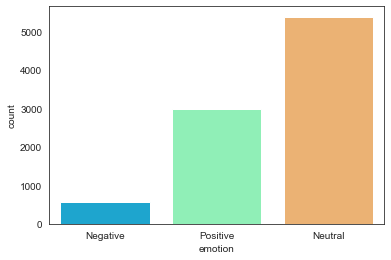

In [108]:
sns.countplot(x='emotion',data=data,palette='rainbow')

The majority of the tweets indicated "neutral" or "no emotion" towards the brand and product. The negative emotion category is significantly lower than positive and neutral categories. Adjusting for the imbalance will likely be necessary for developing a predictive model.

# Train/Test/Split

In [109]:
from sklearn.model_selection import train_test_split

X = data['tweet']
y = data['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size=0.30,
                                                    random_state=123)

In [110]:
y_test.value_counts()

Neutral     1617
Positive     894
Negative     171
Name: emotion, dtype: int64

In [111]:
y_train.value_counts()

Neutral     3772
Positive    2084
Negative     399
Name: emotion, dtype: int64

# LinearSVC

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk import TweetTokenizer

In [113]:
# Initialize the TweetTokenizer

tokenizer = TweetTokenizer(preserve_case=False)

In [114]:
## Make a list of stopwords to remove
from nltk.corpus import stopwords
import string

In [115]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [201]:
additional_words = ['“','”','...','``',"''",'’',"#sxsw",'link',"@mention","}",
                    "{","rt","today","austin","SWSW","sxsw","quot","mention","Google","Apple","iPhone", "iPad"]

In [202]:
#additional_words = ["#sxsw",'link',"@mention","}","{","rt","today","austin"]
# 0.027308
# circles        0.023870
# {              0.022298
# new            0.017287
# store          0.017028
# rt             0.017015
# called         0.016985
# google         0.016169
# today          0.015884
# apple          0.015597
# launch         0.015334
# .              0.015274
# network        0.015067
# social         0.014542
# "              0.014444
# !              0.013275
# ,              0.013166
# possibly       0.010547
# ipad           0.009996
# iphone         0.008850
# major          0.008838
# ?              0.008302
# 2              0.008290
# :              0.007623
# pop-up         0.007126
#               0.006852
# ûï             0.006772
#               0.005971
# (              0.005596
# û              0.005500
# app            0.005128
# -              0.005115
# ...            0.004798
# line           0.004170
# austin         0.004025
# cool           0.003912
# '              0.003755
# #iphone        0.003701
# #ubersocial    0.003433
# sxsw           0.003430
# )              0.003387
# sponsored      0.003374
# great          0.003293
# just           0.003266
# design         0.003164
# don't          0.003120
# #sxswi         0.003089

In [203]:
## Add punctuation to stopwords_list
stopwords_list+=string.punctuation
## Add additional_punc to stopwords_list
stopwords_list.extend(additional_words)
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [204]:
linear_svc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',
                                                 tokenizer=tokenizer.tokenize)),
                     ('clf', LinearSVC(class_weight='balanced'))])

linear_svc.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1c1b3bd240>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight='balanced', dual=T

In [205]:
predictions = linear_svc.predict(X_test)

## Metrics

Train score= 0.9322142286171063
Test score= 0.6849366144668159

              precision    recall  f1-score   support

    Negative       0.46      0.37      0.41       171
     Neutral       0.75      0.77      0.76      1617
    Positive       0.60      0.58      0.59       894

    accuracy                           0.68      2682
   macro avg       0.60      0.58      0.59      2682
weighted avg       0.68      0.68      0.68      2682



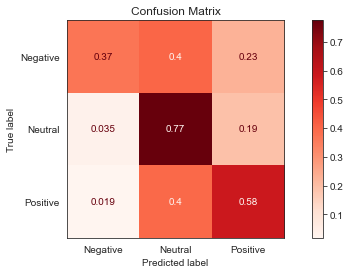

In [121]:
from sklearn import metrics

evaluate_model(linear_svc, y_train, y_test, predictions, X_train, X_test)

LinearSVC provided a high training score and above average test score. Recall for the "Negative" class is .37, a first benchmark.

# MulitinomialNB

In [122]:
from sklearn.naive_bayes import MultinomialNB

In [123]:
text_mnb = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', MultinomialNB())])

# Feed the training data through the pipeline
text_mnb.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1c1b3bd240>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, cl

In [124]:
predictions = text_mnb.predict(X_test)

## Metrics

Train score= 0.750599520383693
Test score= 0.6528709917971663

              precision    recall  f1-score   support

    Negative       1.00      0.01      0.01       171
     Neutral       0.64      0.97      0.77      1617
    Positive       0.74      0.21      0.33       894

    accuracy                           0.65      2682
   macro avg       0.79      0.39      0.37      2682
weighted avg       0.70      0.65      0.58      2682



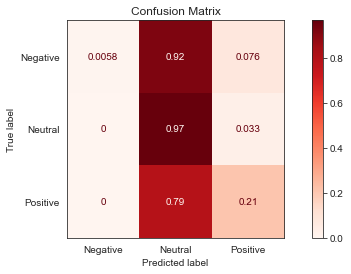

In [125]:
evaluate_model(text_mnb, y_train, y_test, predictions, X_train, X_test)

MultinomialNB showed dismal results for the "Negative" class.

# SGDClassifier

In [126]:
from sklearn.linear_model import SGDClassifier

In [127]:
text_sgdc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', SGDClassifier())])


text_sgdc.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

In [128]:
predictions = text_sgdc.predict(X_test)

## Metrics

Train score= 0.8970423661071143
Test score= 0.6991051454138703

              precision    recall  f1-score   support

    Negative       0.65      0.27      0.39       171
     Neutral       0.73      0.84      0.78      1617
    Positive       0.63      0.53      0.58       894

    accuracy                           0.70      2682
   macro avg       0.67      0.55      0.58      2682
weighted avg       0.69      0.70      0.69      2682



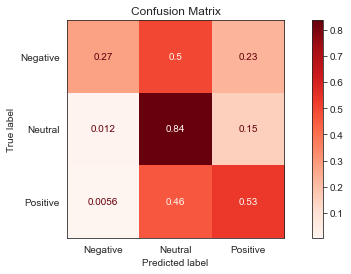

In [129]:
evaluate_model(text_sgdc, y_train, y_test, predictions, X_train, X_test)

Recall is .28; lower than previous results.

# LogisticRegression

In [130]:
from sklearn.linear_model import LogisticRegression

In [131]:
text_lr = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', LogisticRegression())])

text_lr.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1c1b3bd240>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dua

In [132]:
predictions = text_lr.predict(X_test)

## Metrics

Train score= 0.8203037569944045
Test score= 0.6987322893363161

              precision    recall  f1-score   support

    Negative       0.63      0.07      0.13       171
     Neutral       0.71      0.88      0.79      1617
    Positive       0.65      0.49      0.56       894

    accuracy                           0.70      2682
   macro avg       0.67      0.48      0.49      2682
weighted avg       0.69      0.70      0.67      2682



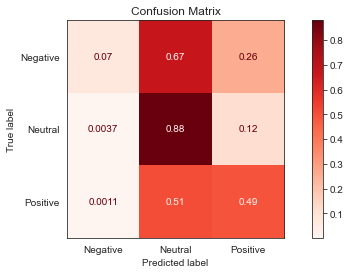

In [133]:
evaluate_model(text_lr, y_train, y_test, predictions, X_train, X_test)

Logistic Regression also showing low recall results at 0.07.

# RandomForestClassifier

In [134]:
from sklearn.ensemble import RandomForestClassifier

In [135]:
text_rfc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', RandomForestClassifier(class_weight='balanced'))])

text_rfc.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                               

In [136]:
predictions = text_rfc.predict(X_test)

## Metrics

Train score= 0.997761790567546
Test score= 0.6797166293810589

              precision    recall  f1-score   support

    Negative       0.75      0.18      0.28       171
     Neutral       0.69      0.89      0.77      1617
    Positive       0.65      0.40      0.50       894

    accuracy                           0.68      2682
   macro avg       0.69      0.49      0.52      2682
weighted avg       0.68      0.68      0.65      2682



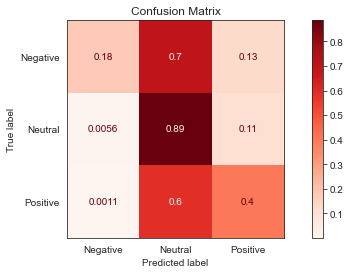

In [137]:
evaluate_model(text_rfc, y_train, y_test, predictions, X_train, X_test)

Random Forest showed a recall result about in the middle of the spectrum of all classifiers tried. This particular algorithm has proven successful in similar scenarios; I will further optimize it with over/under sampling techniques.

## Oversampling

In [138]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(lowercase=True, stop_words=stopwords_list,
                            tokenizer=tokenizer.tokenize)

rfc = RandomForestClassifier(class_weight='balanced')

# The under-sampling models significantly outperformed the over-sampling models. 

## RFC - RandomOverSampler

In [139]:
ROS_pipeline = make_pipeline(tfidf, RandomOverSampler(random_state=123), rfc)

In [140]:
ROS_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourse...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf

In [141]:
predictions = ROS_pipeline.predict(X_test)

### Metrics

Train score= 0.9649880095923261
Test score= 0.6815809097688292

              precision    recall  f1-score   support

    Negative       0.69      0.27      0.39       171
     Neutral       0.72      0.81      0.76      1617
    Positive       0.60      0.53      0.56       894

    accuracy                           0.68      2682
   macro avg       0.67      0.54      0.57      2682
weighted avg       0.68      0.68      0.67      2682



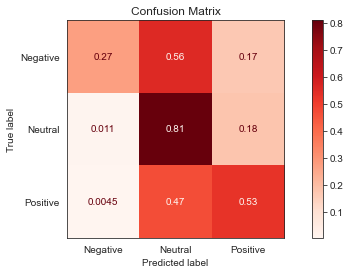

In [142]:
evaluate_model(ROS_pipeline, y_train, y_test, predictions, X_train, X_test)

## RFC - SMOTE

In [143]:
SMOTE_pipeline = make_pipeline(tfidf, SMOTE(random_state=123),rfc)
SMOTE_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourse...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf

In [144]:
predictions = SMOTE_pipeline.predict(X_test)

### Metrics

Train score= 0.9657873701039169
Test score= 0.6845637583892618

              precision    recall  f1-score   support

    Negative       0.73      0.27      0.39       171
     Neutral       0.71      0.83      0.77      1617
    Positive       0.61      0.49      0.55       894

    accuracy                           0.68      2682
   macro avg       0.68      0.53      0.57      2682
weighted avg       0.68      0.68      0.67      2682



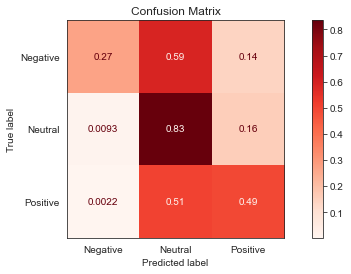

In [145]:
evaluate_model(SMOTE_pipeline, y_train, y_test, predictions, X_train, X_test)

## RFC - ADASYN

In [146]:
ADASYN_pipeline = make_pipeline(tfidf, ADASYN(ratio='minority',random_state=123),rfc)

In [147]:
ADASYN_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourse...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf

In [148]:
predictions = ADASYN_pipeline.predict(X_test)

### Metrics

Train score= 0.9657873701039169
Test score= 0.6834451901565995

              precision    recall  f1-score   support

    Negative       0.71      0.28      0.40       171
     Neutral       0.71      0.84      0.77      1617
    Positive       0.62      0.47      0.53       894

    accuracy                           0.68      2682
   macro avg       0.68      0.53      0.57      2682
weighted avg       0.68      0.68      0.67      2682



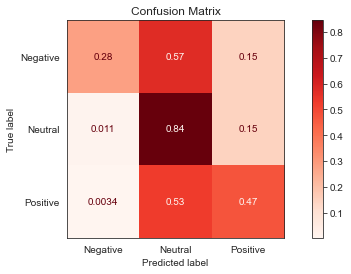

In [149]:
evaluate_model(ADASYN_pipeline, y_train, y_test, predictions, X_train, X_test)

## Undersampling

## RFC Random Under Sampler

In [150]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler

RUS_pipeline = make_pipeline(tfidf, RandomUnderSampler(random_state=123),rfc)


In [151]:
RUS_pipeline.fit(X_train, y_train)  
predictions = RUS_pipeline.predict(X_test)

### Metrics

Train score= 0.5984012789768185
Test score= 0.5260999254287845

              precision    recall  f1-score   support

    Negative       0.16      0.61      0.26       171
     Neutral       0.74      0.57      0.64      1617
    Positive       0.48      0.44      0.46       894

    accuracy                           0.53      2682
   macro avg       0.46      0.54      0.45      2682
weighted avg       0.62      0.53      0.56      2682



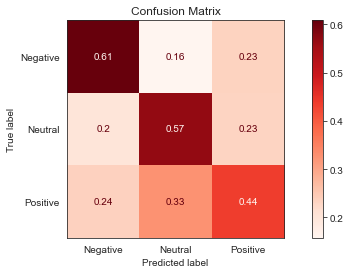

In [152]:
evaluate_model(RUS_pipeline, y_train, y_test, predictions, X_train, X_test)

Random Under Sampler shows the best results so far at 0.71 recall. I tried a few variations of Near Miss to exahaust all possibilities.

## RFC - Near Miss 1

In [210]:
NM1_pipeline = make_pipeline(tfidf, NearMiss(ratio='not minority',random_state=123, version = 1),rfc)
NM1_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourse...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf

In [211]:
predictions = NM1_pipeline.predict(X_test)

### Metrics

Train score= 0.3247002398081535
Test score= 0.2975391498881432

              precision    recall  f1-score   support

    Negative       0.08      0.73      0.15       171
     Neutral       0.80      0.22      0.35      1617
    Positive       0.42      0.35      0.38       894

    accuracy                           0.30      2682
   macro avg       0.43      0.43      0.29      2682
weighted avg       0.63      0.30      0.35      2682



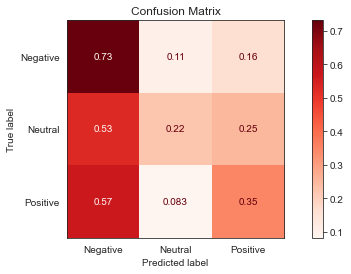

In [212]:
evaluate_model(NM1_pipeline, y_train, y_test, predictions, X_train, X_test)

In [213]:
importances = NM1_pipeline.named_steps['randomforestclassifier'].feature_importances_

In [214]:
test = pd.DataFrame(importances)

In [215]:
test.head()

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000028
4,0.000000


In [216]:
fn = NM1_pipeline.named_steps['tfidfvectorizer'].get_feature_names()

In [217]:
len(fn)

8934

In [218]:
treedf = pd.Series(NM1_pipeline.named_steps['randomforestclassifier'].feature_importances_,
                      index=NM1_pipeline.named_steps['tfidfvectorizer'].get_feature_names())

In [255]:
top_words = treedf.sort_values(ascending=False).head(10).index#.plot(kind='bar')

In [263]:
word_dict={}
for word in top_words:
    word_df=data.copy()



    word_df["contains"] = word_df["tweet"].str.contains(word)

    #word_df.groupby(["emotion", "contains"]).count()["tweet"]

    emotions = ["Negative", "Neutral", "Positive"]

    emo_dict = {}
    for emo in emotions:
        emo_df = word_df.groupby("emotion").get_group(emo)
        emo_df["contains"].value_counts(normalize=True)
        emo_dict[emo] = emo_df["contains"].value_counts(normalize=True).loc[True]

    word_dict[word]= pd.Series(emo_dict, name=word)

In [268]:
pd.DataFrame(word_dict).T

,Negative,Neutral,Positive
social,0.036842,0.039711,0.020819
new,0.085965,0.079050,0.095702
apple,0.033333,0.038597,0.065480
store,0.057895,0.115235,0.140363
google,0.040351,0.056040,0.050705
network,0.014035,0.023938,0.011081
circles,0.003509,0.010763,0.004701
ipad,0.040351,0.046020,0.058093
called,0.005263,0.011319,0.004701
launch,0.033333,0.059751,0.045668


A wonderful result of 0.80 recall on the negative class. Unsure if it's possible to improve further, I tested a grid search of the most relevant parameters.

## Grid_RFC - Near Miss 1

In [ ]:
params = {'randomforestclassifier__criterion':['gini','entropy'],
             'randomforestclassifier__max_depth':[None, 5, 3, 10],
             'randomforestclassifier__min_samples_leaf': [1,2,3],
         'randomforestclassifier__max_features':['auto','sqrt',3,5,10,30,70]}


In [ ]:
NM1_pipeline = make_pipeline(tfidf, NearMiss(ratio='not minority',random_state=123, 
                                             version = 1),rfc)
#NM1_pipeline.named_steps

In [ ]:
 
grid = GridSearchCV(NM1_pipeline, cv=5, n_jobs=-1, param_grid=params ,
                    scoring='recall_macro')

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

Research best estimator from grid

In [ ]:
best_pipe = grid.best_estimator_

In [ ]:
best_pipe

In [ ]:
best_pipe.fit(X_train,y_train)

In [ ]:
predictions = best_pipe.predict(X_test)

In [ ]:
evaluate_model(best_pipe, y_train, y_test, predictions, X_train, X_test)

Unfortunately, the grid search did not prove to be effective for further optimization as is evident by the .07 drop in recall.

In [ ]:
#best_pipe.named_steps['tfidfvectorizer'].get_feature_names()

### Metrics

## RFC - Near Miss 2

In [ ]:
NM2_pipeline = make_pipeline(tfidf, NearMiss(ratio='not minority',random_state=123, version = 2),rfc)
NM2_pipeline.fit(X_train, y_train)  

In [ ]:
predictions = NM2_pipeline.predict(X_test)

### Metrics

In [ ]:
evaluate_model(NM2_pipeline, y_train, y_test, predictions, X_train, X_test)

## RFC - Near Miss 3

In [ ]:
NM3_pipeline = make_pipeline(tfidf, NearMiss(ratio='not minority',random_state=123, version = 3, n_neighbors_ver3=4),rfc)
NM3_pipeline.fit(X_train, y_train)

In [ ]:
predictions = NM3_pipeline.predict(X_test)

### Metrics

In [ ]:
evaluate_model(NM3_pipeline, y_train, y_test, predictions, X_train, X_test)

# Visualizations

In [172]:
from wordcloud import WordCloud

In [206]:
wcdata = data['emotion']== "Negative"
wcdata_pos = data['emotion']== "Positive"

In [207]:
pd.set_option('display.max_colwidth', 10000)
data[wcdata_pos].head()

,tweet,product,emotion,text length,token_length
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,139,22
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,79,15
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,131,17
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive,138,28
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive,129,17


An example of negative tweets.

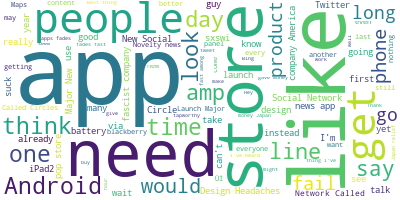

In [208]:
wordcloud = WordCloud(stopwords=stopwords_list, background_color="white", max_words=100, 
                      contour_width=3, 
                      contour_color='steelblue')

wordcloud.generate(data[wcdata]['tweet'].to_string())

wordcloud.to_image()

In [228]:
# wordcloud.generate(",".join(data[wcdata_pos]['tweet']))#.to_string())

# wordcloud.to_image()

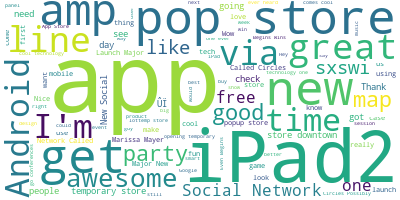

In [229]:
wordcloud.generate(data[wcdata_pos]['tweet'].to_string())

wordcloud.to_image()

#"get","app",

The most popular words to appear in the negative tweets.

# Conclusion

After exploring multiple classifiers and balancing techniques, the Random Forest model with the first variation of Near Miss performed best with a recall of 0.80. With this particular data set terms such as "SXSW", "RT", "mention", "Google" and "Apple" appeared most frequently in the negative tweets.

# Recommendations

Brand managers and product developers might want to review the negative tweets such as:

".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW."

"@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw"

"@mention - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW"

Addressing the concerns of product users will go a long way to improve products and brand reputation which in turn will make the business more successful.

In [ ]:
import nltk
nltk.download('vader_lexicon')

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [ ]:
data.head()

In [ ]:
data['scores'] = data['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))

In [ ]:
data.head()

In [ ]:

data['compound']= data['scores'].apply(lambda score_dict: score_dict['compound'])

In [ ]:
data.head()

In [ ]:
def emotion_p(c):
    if c >=0.2: 
        output = 'Positive'
    elif c <=-0.2:
        output = 'Negative'
    else:
        output = 'Neutral'
    return output
    

In [ ]:
emotion_p(0)

In [ ]:
data['comp_score'] = data['compound'].apply(emotion_p)

In [ ]:
data.head()

In [ ]:
data['product'].value_counts()

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [ ]:
accuracy_score(data['emotion'],data['comp_score'])